In [1]:
# k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr
# ! conda install -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '15m'

# start epoch till now
start_time = 1672535100000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)
    
    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [5]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

               Close_Time     Open    Close     High      Low      Volume
0     2023-01-01 09:29:59  1195.38  1195.45  1195.61  1195.01    534.1101
1     2023-01-01 09:44:59  1195.45  1194.92  1195.58  1194.72    815.5492
2     2023-01-01 09:59:59  1194.92  1196.02  1196.37  1194.92    631.7476
3     2023-01-01 10:14:59  1196.01  1195.22  1196.02  1194.11   1695.5041
4     2023-01-01 10:29:59  1195.21  1196.12  1196.13  1195.02    775.1099
...                   ...      ...      ...      ...      ...         ...
8113  2023-03-26 22:59:59  1769.72  1763.63  1773.24  1753.02  22126.6156
8114  2023-03-26 23:14:59  1763.63  1767.51  1769.64  1759.82   7113.8352
8115  2023-03-26 23:29:59  1767.40  1767.87  1769.82  1763.74   4594.4155
8116  2023-03-26 23:44:59  1767.87  1762.61  1769.45  1762.48   2986.9247
8117  2023-03-26 23:59:59  1762.60  1761.23  1764.34  1760.25    875.9884

[8118 rows x 6 columns]


In [6]:
df = rawdf.copy()

In [7]:
def indicators(df):

# ema
    for i in (8, 18, 38):
        df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# atr8
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()

# kd
    kd_int = 14
    d_int = 3
   
    kddf = pd.DataFrame()
    kddf[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kddf[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slowk'] = (df['Close'] - kddf[str(kd_int) + '-Low'])*100/(kddf[str(kd_int) + '-High'] - kddf[str(kd_int) + '-Low'])
    df['slowd'] = df['slowk'].rolling(d_int).mean()
    
    return df

def checkcross(df):
    series = df['slowk'] > df['slowd']
    return series.diff()

In [8]:
indicators(df)
df['kd_cross'] = checkcross(df)
print(df)

               Close_Time     Open    Close     High      Low      Volume  \
0     2023-01-01 09:29:59  1195.38  1195.45  1195.61  1195.01    534.1101   
1     2023-01-01 09:44:59  1195.45  1194.92  1195.58  1194.72    815.5492   
2     2023-01-01 09:59:59  1194.92  1196.02  1196.37  1194.92    631.7476   
3     2023-01-01 10:14:59  1196.01  1195.22  1196.02  1194.11   1695.5041   
4     2023-01-01 10:29:59  1195.21  1196.12  1196.13  1195.02    775.1099   
...                   ...      ...      ...      ...      ...         ...   
8113  2023-03-26 22:59:59  1769.72  1763.63  1773.24  1753.02  22126.6156   
8114  2023-03-26 23:14:59  1763.63  1767.51  1769.64  1759.82   7113.8352   
8115  2023-03-26 23:29:59  1767.40  1767.87  1769.82  1763.74   4594.4155   
8116  2023-03-26 23:44:59  1767.87  1762.61  1769.45  1762.48   2986.9247   
8117  2023-03-26 23:59:59  1762.60  1761.23  1764.34  1760.25    875.9884   

            ema_8       ema_18       ema_38       atr        rsi      slowk

In [9]:
def conditions(df):
    # k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr

    for index, row in df.iterrows():
        # c1
        df['c1'] = df['kd_cross']
        # c2
        df['c2'] = df['Close'] >= df['ema_8']
        # c3
        df['c3'] = df['ema_8'] >= df['ema_18']
        # c4
        df['c4'] = df['ema_18'] >= df['ema_38']

    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3 & df.c4, 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [10]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,ema_8,ema_18,ema_38,atr,rsi,slowk,slowd,kd_cross,c1,c2,c3,c4,signal,openbuy
0,2023-01-01 09:29:59,1195.38,1195.45,1195.61,1195.01,534.1101,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
1,2023-01-01 09:44:59,1195.45,1194.92,1195.58,1194.72,815.5492,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
2,2023-01-01 09:59:59,1194.92,1196.02,1196.37,1194.92,631.7476,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
3,2023-01-01 10:14:59,1196.01,1195.22,1196.02,1194.11,1695.5041,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
4,2023-01-01 10:29:59,1195.21,1196.12,1196.13,1195.02,775.1099,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8113,2023-03-26 22:59:59,1769.72,1763.63,1773.24,1753.02,22126.6156,1776.252597,1775.293849,1769.312557,9.180543,42.794886,22.113381,26.087641,False,False,False,True,True,False,False
8114,2023-03-26 23:14:59,1763.63,1767.51,1769.64,1759.82,7113.8352,1774.309798,1774.474496,1769.220118,9.226218,46.147400,30.200083,22.436463,True,True,False,False,True,False,False
8115,2023-03-26 23:29:59,1767.40,1767.87,1769.82,1763.74,4594.4155,1772.878732,1773.779286,1769.150881,9.001488,46.460918,30.950396,27.754620,False,False,False,False,True,False,False
8116,2023-03-26 23:44:59,1767.87,1762.61,1769.45,1762.48,2986.9247,1770.596791,1772.603572,1768.815451,8.856382,42.561989,19.987495,27.045991,True,True,False,False,True,False,False


In [11]:
buydf = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan
close_val = buydf['Close']
atr_val = buydf['atr']

for index, row in buydf.iterrows():

    if index == 0:
        continue
    
    elif buydf.at[index, 'openbuy'] == True:
   
        buydf.at[index, 'entry_p'] = close_val.shift(1).at[index]
        buydf.at[index, 'stop_loss'] = close_val.shift(1).at[index] - 3 * atr_val.shift(1).at[index]
        buydf.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = buydf.at[index, 'stop_loss']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and buydf.at[index, 'Close'] < stop_loss:
        buydf.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit
    elif (buydf.at[index, 'High'] >= close_val.shift(1).at[index] + 4 * atr_val.shift(1).at[index]) and in_position == True:
        buydf.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan

buydf.to_csv('buydf.csv')
        
raw_entry_df = buydf.copy()

# 過濾有訊號或事件發生的Ｋ線
buydf = buydf[(buydf['openbuy'] == True) |
              (buydf['signal'] == True) | 
              (buydf['position'] == 'Buy') |
              (buydf['position'] == 'Sell') |
              (buydf['position'] == 'Stop')]


print(buydf)


               Close_Time     Open    Close     High      Low      Volume  \
38    2023-01-01 18:59:59  1195.66  1197.14  1197.19  1195.66    580.9124   
39    2023-01-01 19:14:59  1197.14  1196.92  1197.41  1196.59   1058.8885   
40    2023-01-01 19:29:59  1196.93  1196.16  1196.93  1196.08    618.4101   
42    2023-01-01 19:59:59  1196.04  1196.34  1196.35  1195.72    403.6366   
43    2023-01-01 20:14:59  1196.35  1197.21  1197.55  1195.83   1232.3220   
...                   ...      ...      ...      ...      ...         ...   
8107  2023-03-26 21:29:59  1774.12  1774.87  1777.00  1773.22   2425.5664   
8108  2023-03-26 21:44:59  1774.87  1788.97  1801.00  1774.87  24093.6760   
8110  2023-03-26 22:14:59  1796.48  1788.80  1796.99  1786.94   8296.0286   
8111  2023-03-26 22:29:59  1788.80  1781.31  1789.36  1780.84   5904.9382   
8113  2023-03-26 22:59:59  1769.72  1763.63  1773.24  1753.02  22126.6156   

            ema_8       ema_18       ema_38       atr  ...  kd_cross     c1

In [12]:
# 部位回測

posdf = buydf.copy()
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Buy') |
              (posdf['position'] == 'Sell') |
              (posdf['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'ema_8', 'ema_18', 'ema_38', 'atr', 'kd_cross', 'position','entry_p', 'stop_loss']
pos = posdf[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Sell':
#             pos.at[index, 'exit_p'] = pos.at[index, 'Close']
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'Close'] + 4 * pos.at[i, 'atr']
                break

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break
        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算進場最大部位來代表總進場成本，以計算報酬率
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Buy', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)

wins = pos['position'].str.count('Sell').sum()
loses = pos['position'].str.count('Stop').sum()
total_pos = pos['position']
win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Entry': [round(max_entry, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)



               Close_Time     Open    Close     High      Low        ema_8  \
0     2023-01-01 19:14:59  1197.14  1196.92  1197.41  1196.59  1196.192284   
1     2023-01-01 19:29:59  1196.93  1196.16  1196.93  1196.08  1196.185110   
2     2023-01-01 20:14:59  1196.35  1197.21  1197.55  1195.83  1196.421471   
3     2023-01-01 20:59:59  1197.03  1197.17  1197.58  1197.02  1196.887331   
4     2023-01-02 00:59:59  1196.88  1197.34  1197.98  1196.80  1196.607095   
...                   ...      ...      ...      ...      ...          ...   
1129  2023-03-26 20:59:59  1773.84  1775.57  1777.99  1773.16  1773.602909   
1130  2023-03-26 21:29:59  1774.12  1774.87  1777.00  1773.22  1773.973859   
1131  2023-03-26 21:44:59  1774.87  1788.97  1801.00  1774.87  1777.306335   
1132  2023-03-26 22:29:59  1788.80  1781.31  1789.36  1780.84  1782.758783   
1133  2023-03-26 22:59:59  1769.72  1763.63  1773.24  1753.02  1776.252597   

           ema_18       ema_38       atr kd_cross position  ent

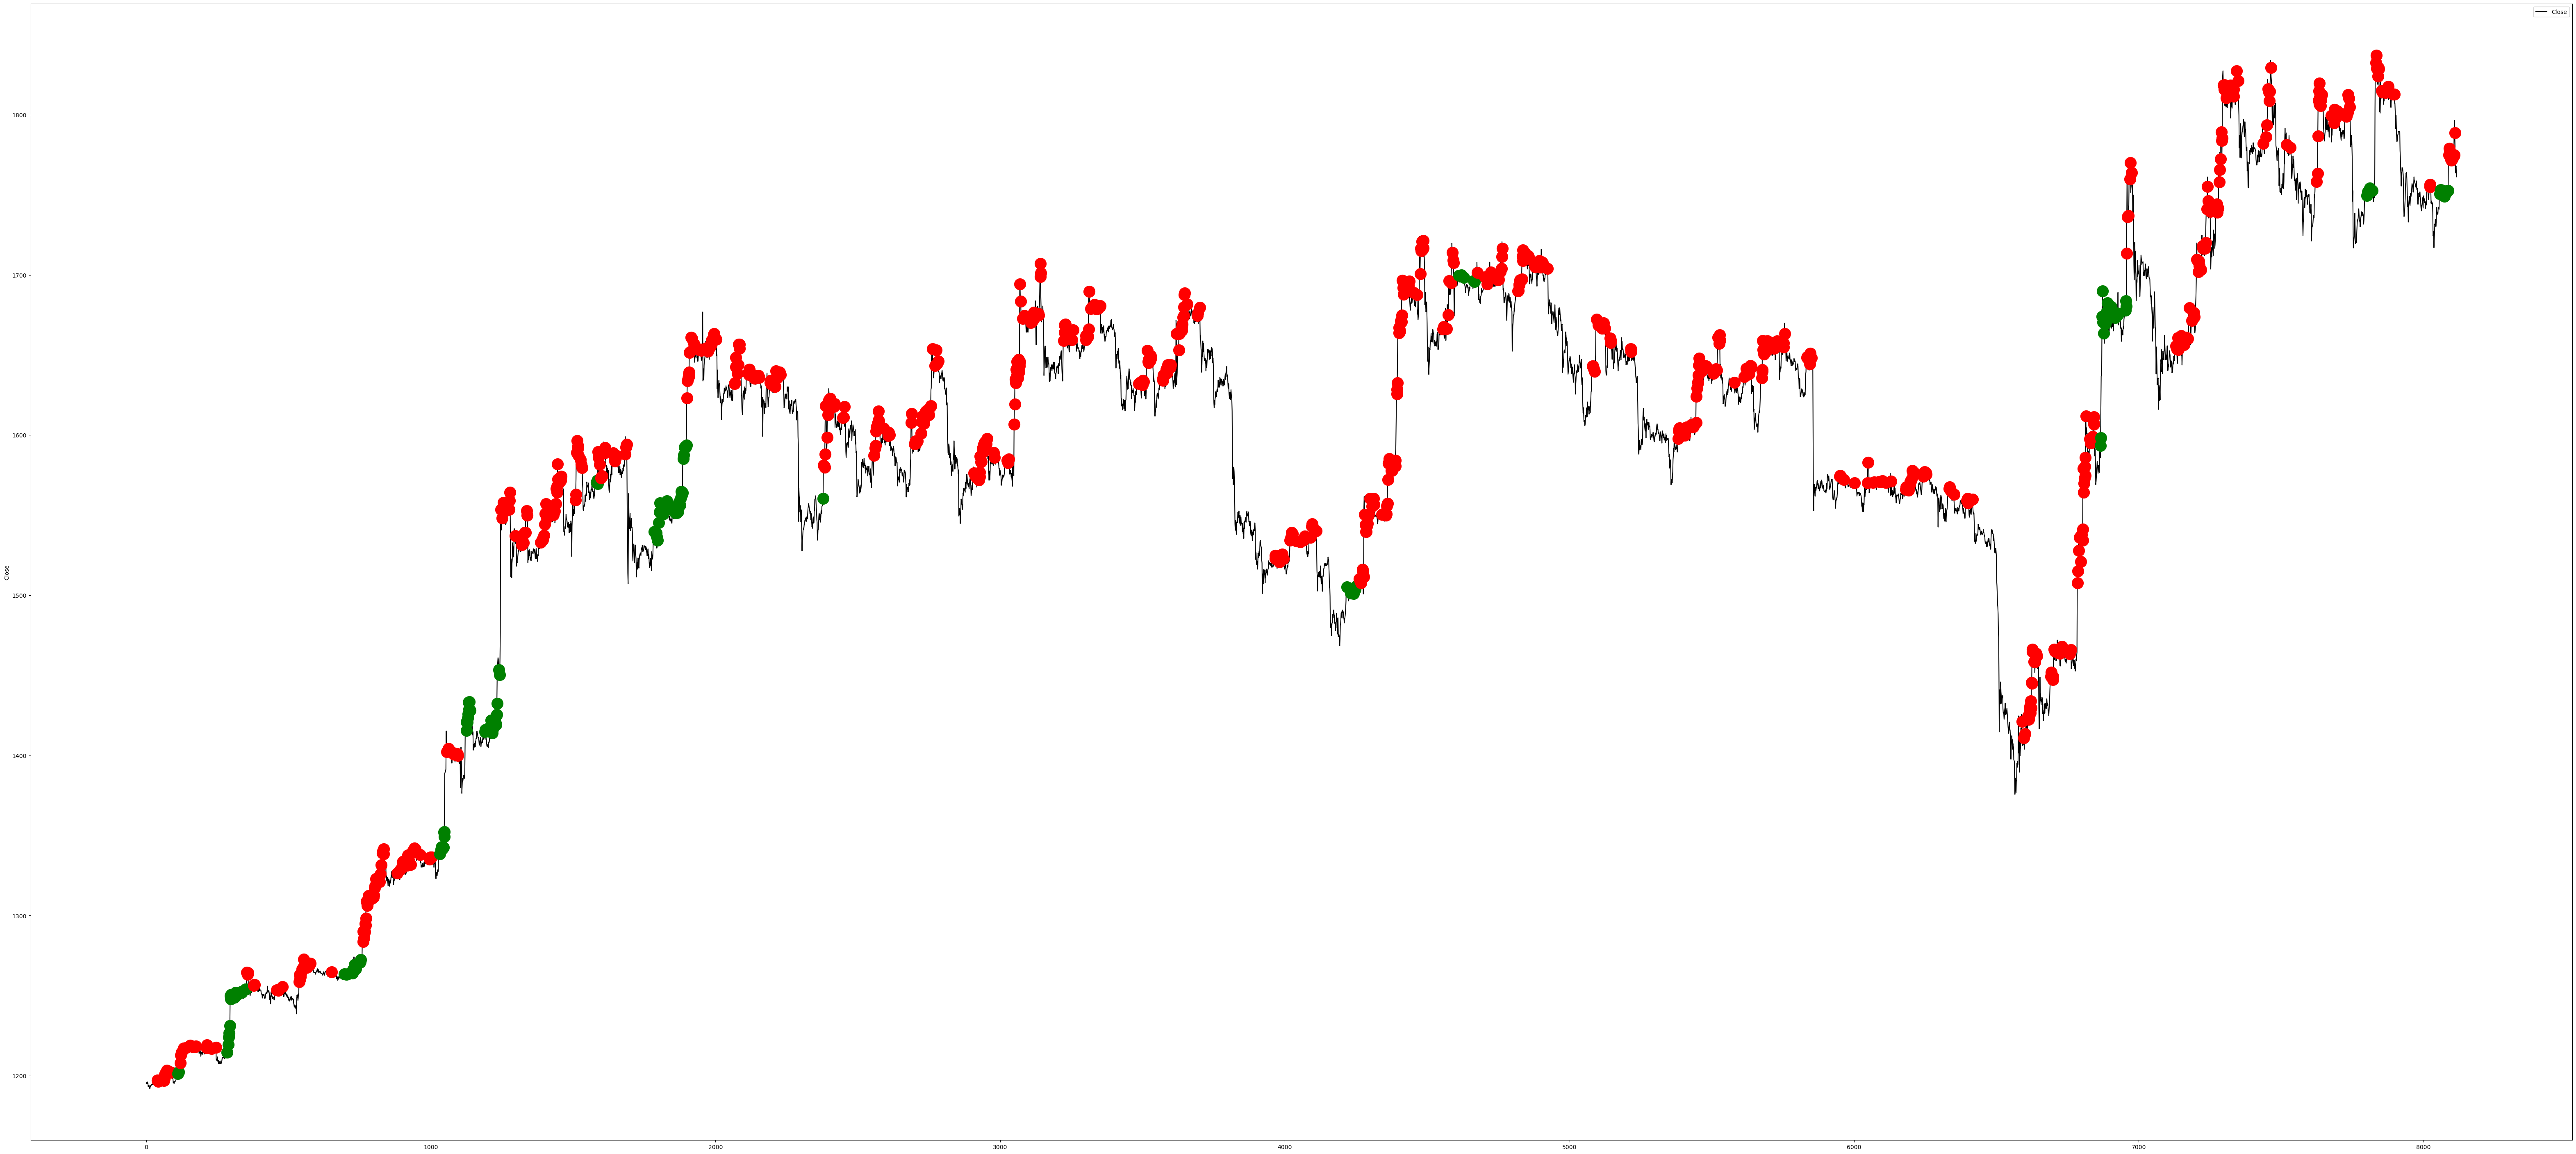

In [13]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')

i = 0
while i < len(plt_df):
    if pd.isna(plt_df.position[i]):
        i += 1
    elif plt_df.position[i] == 'Buy':
        j = i + 1
        while j < len(plt_df) and (pd.isna(plt_df.position[j]) or plt_df.position[j] == 'Buy'):
            j += 1
        if j < len(plt_df) and plt_df.position[j] == 'Sell':
            # Paint all previous 'Buy's green dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'go', label='_', markersize=20)
            i = j
        elif j < len(plt_df) and plt_df.position[j] == 'Stop':
            # Paint all previous 'Buy's red dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'ro', label='_', markersize=20)
            i = j + 1
        else:
            i = j
    else:
        i += 1

plt.legend()
plt.show()


# 之所以出現大量紅點，原因為：連續加倉會調整整個部位停利和停損，因此一些進倉部位會因為調高後的＂整個部位＂停損而出場，但該入場損益依舊為正
# 意思是該部位之停損已經高於許多前面部位之進場點位